# Segmentacja obrazów
Opracowanie: A.Florkowska
\
Repozytorium: https://github.com/aflorkowska/Image-Processing/tree/main

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from scipy import ndimage as nd
from skimage import color, io, segmentation
from skimage.feature import blob_dog, blob_log, blob_doh
from skimage import measure
from skimage import feature
import scipy.signal as signal
import time
import queue
from IPython.display import Image

# Segmentacja 
To proces podziału obrazu na mniejsze obszary (= segmenty), które są w pewien sposób jednorodne lub mają wspólne cechy. Dzięki temu możliwe jest wyodrębnienie i wizualizację poszczególnych struktur (= fragmentów, obiektów) obrazu, umożliwiając jednocześnie eliminację elementów niepożądanych np. szumów.

Można wyróżnić kilka rodzajów segmentacji:
- lokalna / globalna
  * lokalna - koncentruje się na mniejszych obszarach obrazu podczas jego analizy (m.in. lokalnych cechy i różnic między pikselami / wokselsami lub ich grupami). W ten sposób tworzy lokalne kryteria segmentacji
  * globalna - do analizy obrazu stosowane jest jednolite kryterium segmentacji na wszystkich pikselach / wokselach
- twarda / miękka
  * twarda - zwraca informacje o przynależności piksela do konkretnego podzbioru i jest kategoryczna, czyli żaden piksel / woksel nie należy równocześnie do dwóch podzbiorów (są one rozłączne)
  * miękka - określa prawdopodobieństwo przynależności do określonego podzbioru
- pojedynczoetykietowa / wieloetykietowa
  * pojedynczoetykietowa - każdy piksel / woksel przypisany jest do dokładnie jednej klasy
  * wieloetykietowa - każdy piksel / woksel może być przypisany do wielu klas jednocześnie np. gdy obiekty nachodzą na siebie lub obiekt posiada kilka właściwości, które są analizowane

Główne techniki segmentacji obrazu:

- na podstawie progowania
- oparte o krawędzie
- oparta o regiony
- z wykorzystaniem technik uczenia maszynowego i głębokiego uczenia

Zastosowanie segmentacji można odnaleźć w wielu dziedzinach, między innymi:

- medycyna: segmentacje danych z MRI czy CT do identyfikacji różnych tkanek, organów czy zmian patologicznych
- automatyka i robotyka: do nawigacji, wykrywania przeszkód czy rozpoznawania obiektów
- przetwarzanie obrazów satelitarnych: do analizy terenu, wykrywania zmian środowiskowych

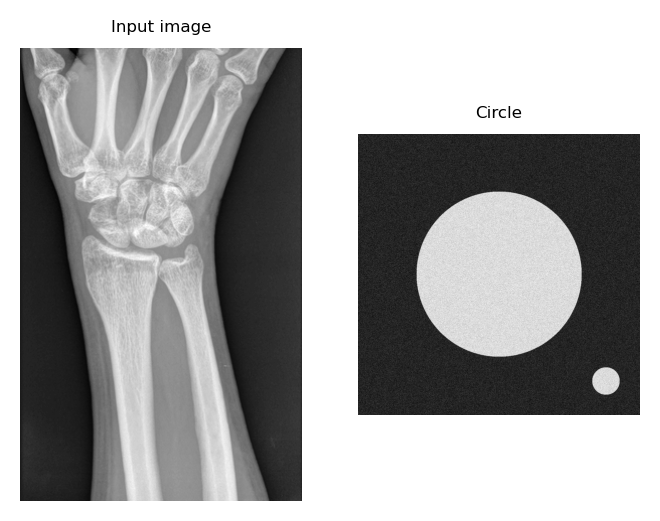

In [3]:
def generate_circle(y_size, x_size, x_origin, y_origin, radius):
    image = np.zeros((y_size, x_size))
    x_grid, y_grid = np.meshgrid(np.arange(x_size), np.arange(y_size))
    indices = np.square((x_grid - x_origin)) + np.square((y_grid-y_origin)) < radius*radius
    image[indices] = 1
    return image

normalize = lambda image: (image - np.min(image)) / (np.max(image) - np.min(image)) 
image = io.imread(".././images/example1.png")
image = image[:,:,0:3]
image = color.rgb2gray(image)
image = normalize(image)

y_size = 1024
x_size = 1024
circle = generate_circle(y_size, x_size, 512, 512, 300)
circle_2 = generate_circle(y_size, x_size, 900, 900, 50)
circle = np.logical_or(circle, circle_2)
circle = circle + (np.random.random((y_size, x_size))-0.5)*0.4
circle = normalize(circle)

plt.figure(figsize=(4, 6), dpi=200)
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.title("Input image", fontsize=6)
plt.subplot(1, 2, 2)
plt.imshow(circle, cmap='gray')
plt.axis('off')
plt.title("Circle", fontsize=6)
plt.show()

# Progowanie
Najprostsza forma segmentacji, która polega na wyborze wartości progu i klasyfikacji wszystkich pikseli obrazu na podstawie tego progu. Piksele powyżej progu mogą być klasyfikowane jako obiekt, a poniżej jako tło. Czasami ustalane są dwa progi, wtedy co to między wartościami progu traktowane jest jako obiekt, reszta jako tło.

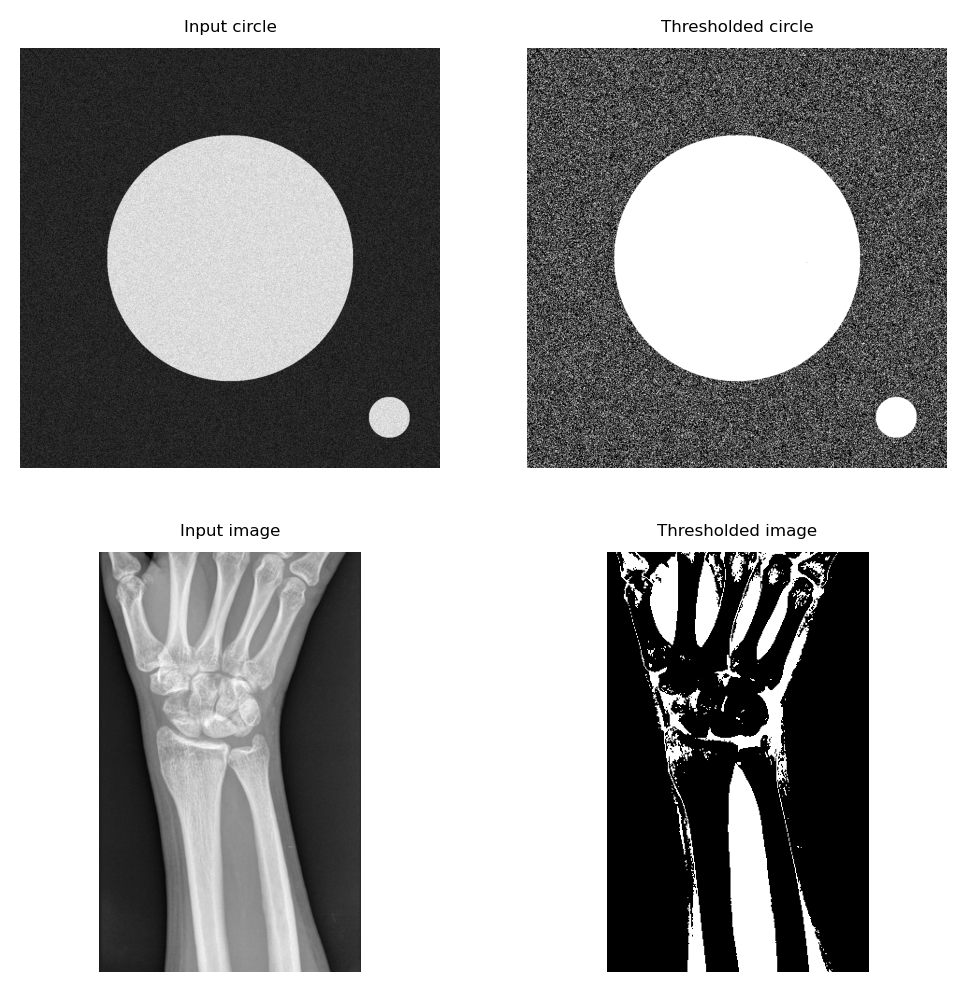

In [5]:
def image_threshold(image, lower, upper):
    return np.logical_and(image > lower, image < upper)

circle_thresholded = image_threshold(circle, 0.2, 1)
image_thresholded = image_threshold(image, 0.48, 0.64)

plt.figure(figsize=(6, 6), dpi=200)
plt.subplot(2, 2, 1)
plt.imshow(circle, cmap='gray')
plt.title("Input circle", fontsize=6)
plt.axis('off')
plt.subplot(2, 2, 2)
plt.imshow(circle_thresholded, cmap='gray')
plt.title("Thresholded circle", fontsize=6)
plt.axis('off')
plt.subplot(2, 2, 3)
plt.imshow(image, cmap='gray')
plt.title("Input image", fontsize=6)
plt.axis('off')
plt.subplot(2, 2, 4)
plt.imshow(image_thresholded, cmap='gray')
plt.title("Thresholded image", fontsize=6)
plt.axis('off')
plt.show()

# Segmentacja oparta o regiony 
Polega na grupowaniu pikseli w regiony na podstawie podobnych wartości. Najczęściej stosowane metody to rośnięcie regionów (region growing) i łączenie regionów (region merging).

Algorytm rozrostu obszarów można traktować jako ulepszone progowanie, z dodaną analizą położenia (sąsiedztwa). Innymi słowy, aby piksel został zaliczony do obiektu, oprócz spełnienia kryterium odpowiedniej intensywności, musi sąsiadować z odpowiednimi pikselami (wcześniej zaliczonymi do obiektu).

Metoda ta wymaga:
- zdefiniowania początkowego obiektu - punktu startowy (seed point), który się rozrasta
- kryterium dołączania nowych punktów

Główne 2 typy algorytmów rozrostu regionów:
- lokalny - możliwe jest zdefiniowanie kilku progów, tym samym wyodrębnienia kilku typów obiektów
- globalny - używa jednego progu podziału dla wszystkich pikseli

# Globalny rozrost obszarów - algorytm
1. Obliczenie wartości progu dolnego i górnego, na podstawie wartości piksela początkowego i zdefiniowanego zakresu tolerancji. Innymi słowy: wybierany jest piksel należący do obiektu i ustalany na tej podstawie zakres intensywności dla obiektu.
2. Progowanie obrazu - wybór pikseli spełniających warunek intensywności.
3. Przeprowadzenie dylatacji w celu wygładzenia obrazu.
4. Ponumerowanie znalezionych obiektów o zgodnej intensywności z punktem początkowym.
5. Zdefiniowanie etykiety obiektu, do którego należy punkt początkowy.
6. Segmentacja wybranego obiektu.

Polecam zapoznać się z dokumentacją metody measure.label (https://scipy-lectures.org/packages/scikit-image/index.html#binary-segmentation-foreground-background)

In [6]:
def my_global_region_growing(image, seed, bottom_tolerance, upper_tolerance):
    # THRESHOLDS CALCULATION
    lower_threshold = image[seed] - bottom_tolerance
    upper_threshold = image[seed] + upper_tolerance
    # IMAGE THRESHOLDING 
    img_extraction= image_threshold(image, lower_threshold, upper_threshold)
    # IMAGE DILATION
    img_extraction = nd.binary_dilation(img_extraction , np.ones((3, 3)))
    # SIGNING LABELS
    all_labels= measure.label(img_extraction)
    # DETERMINING OBJECT'S LABEL
    seed_label = all_labels[seed] 
    # SEGMENTATION - CREATING OUTPUT IMAGE
    output_img = np.equal(all_labels, seed_label) 
    return all_labels, output_img

# Lokalny rozrost obszarów - algorytm
1. Wybór punktu początkowego i zakresu tolerancji.
2. Określenie kryterium wzrostu: intensywności i sąsiedztwa przestrzennego
3. Iteracyjne rozszerzanie obszaru: Rozpoczęcie od ziarna i zbadanie jego otoczenie. Jeśli piksel spełnia określone kryteria wzrostu, dodanie go do regionu i rekurencyjne sprawdzenie jego otoczenia.

Algorytm rozrostu obszaru może zostać zaimplementowany w oparciu o jeden z dwóch algorytmów przeszukiwania: przeszukiwania wszerz (BFS - Breath-First Search) i w głąb (DFS - Deep-First Search). Są one popularnymi algorytmami używanymi w grafach do znalezienia ścieżki lub odwiedzenia węzłów w grafie. Różnią się one sposobem przechodzenia przez węzły i sposobem organizacji danych do przechowywania informacji o węzłach do odwiedzenia.

Algorytm przeszukiwania wszerz - BFS

- przechodzi przez graf zaczynając od wybranego wierzchołka (węzła) i odwiedzając najpierw wszystkich jego sąsiadów, a następnie sąsiadów sąsiadów i tak dalej.
- do przechowywania węzłów do odwiedzenia używa się kolejki (queue). Węzły są dodawane do kolejki w miarę ich odwiedzania, a następnie przetwarzane są w kolejności, w jakiej zostały dodane.

Algorytm przeszukiwania w głąb - DFS

- przechodzi przez graf, idąc tak głęboko jak to możliwe wzdłuż każdej gałęzi przed powrotem i odwiedzeniem innych gałęzi.
- do przechowywania węzłów do odwiedzenia używa się stosu (stack). Węzły są dodawane do stosu, a następnie są pobierane z niego w odwrotnej kolejności do której zostały dodane

Podsumowując, BFS jest preferowany, gdy konieczne jest znalezienie najkrótszej ścieżki, podczas gdy DFS jest bardziej użyteczny, gdy konieczne jest badanie wszystkich możliwych gałęzi grafu.

In [40]:
# Local region growing algorithm was implemented based on breath-first search algorithm. 
def get8neighbors(seed, image):
    size = 3
    neighbors = [(seed[0] - 1 + x, seed[1] - 1 + y) for x in range(size) for y in range(size) if not x == y == 1]
    if(seed[0] == 0 or seed[1] == 0):
        neighbors = list(filter(lambda coord: coord[0] >= 0 and coord[1] >= 0, neighbors))
    if(seed[0] == image.shape[0] - 1 or seed[1] == image.shape[1] - 1):
        neighbors = list(filter(lambda coord: coord[0] < image.shape[0] and coord[1] < image.shape[1], neighbors))
    return neighbors

def region_growing_local(image, seed, bottom_tolerance, upper_tolerance):
    # INITIALIZATION
    seed_points = queue.Queue()
    visited_seeds = set() 
    output_image = np.zeros_like(image, dtype=bool)
    # SET SEED AS OBJECT
    output_image[seed] = True
    seed_points.put(seed)
    # RECCURENT REGION GROWING PROCESS
    while(seed_points.qsize() > 0):
        current_seed = seed_points.get()
        # FIND CURRENT SEED'S NEIGHBORS
        neighbors = get8neighbors(current_seed, image)
        for coord in neighbors: 
            # THRESHOLDS CALCULATION
            lower_threshold = image[current_seed] - bottom_tolerance
            upper_threshold = image[current_seed] + upper_tolerance
            # IMAGE THRESHOLDING 
            condition = image_threshold(image[coord], lower_threshold, upper_threshold)
            if condition and not coord in visited_seeds: 
                seed_points.put(coord)
                output_image[coord] = True
                visited_seeds.add(coord) # This line could be also beyond if statement, because of set property - it contains unique value
    return output_image

My global region growing algorithm (RTG image) - time:  0.00299072265625
Skimage global region growing algorithm (RTG image) - time:  0.00952601432800293
My local region growing algorithm (RTG image) - time:  0.5130617618560791


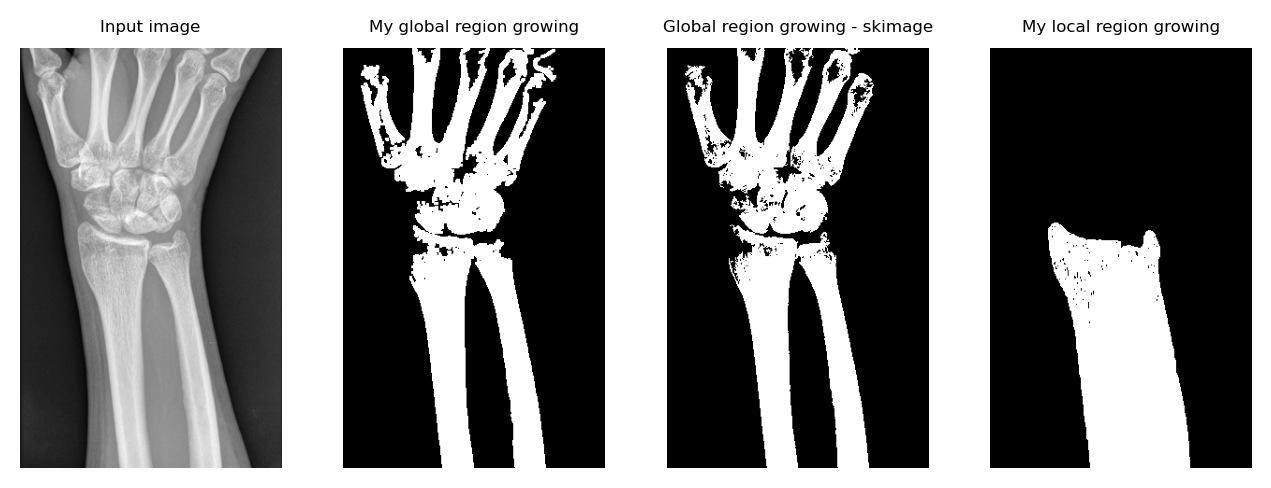

My global region growing algorithm (circle image) - time:  0.01945042610168457
Skimage global region growing algorithm (circle image) - time:  0.04571890830993652
My local region growing algorithm (circle image) - time:  5.971044063568115


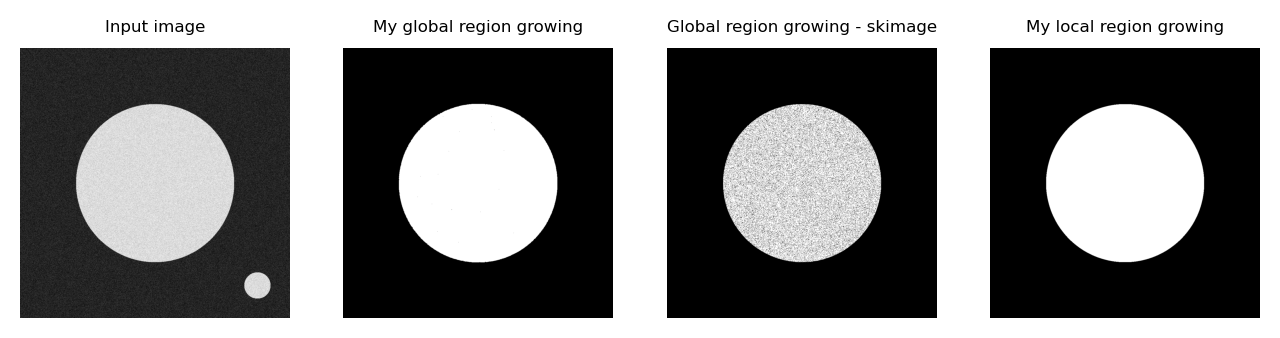

In [66]:
seed_point = (170,130)

# Global region growing
start = time.time()
my_blobs_result, my_img_globalRG = my_global_region_growing(image, seed_point, 0.1, 0.2)
end = time.time()
print("My global region growing algorithm (RTG image) - time: ", end - start)
start = time.time()
img_globalRG = segmentation.flood(image, seed_point, tolerance = 0.15)
end = time.time()
print("Skimage global region growing algorithm (RTG image) - time: ", end - start)
start = time.time()

# Local region growing
my_img_localRG = region_growing_local(image, (220, 100), 0.02, 0.12)
end = time.time()
print("My local region growing algorithm (RTG image) - time: ", end - start)

plt.figure(figsize=(8, 6), dpi=200)
plt.subplot(2, 4, 1)
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.title("Input image", fontsize=6)
plt.subplot(2, 4, 2)
plt.imshow(my_img_globalRG, cmap='gray')
plt.axis('off')
plt.title("My global region growing", fontsize=6)
plt.subplot(2, 4, 3)
plt.imshow(img_globalRG, cmap='gray')
plt.axis('off')
plt.title("Global region growing - skimage", fontsize=6)
plt.subplot(2, 4, 4)
plt.imshow(my_img_localRG, cmap='gray')
plt.axis('off')
plt.title("My local region growing", fontsize=6)
plt.show()


circle_seed_point = (int(circle.shape[0] / 2) - 1, int(circle.shape[1] / 2) - 1)

# Global region growing
start = time.time()
my_blobs_result_circle, my_img_globalRG_circle = my_global_region_growing(circle, circle_seed_point, 0.1, 0.2)
end = time.time()
print("My global region growing algorithm (circle image) - time: ", end - start)
start = time.time()
img_globalRG_circle = segmentation.flood(circle, circle_seed_point, tolerance = 0.15)
end = time.time()
print("Skimage global region growing algorithm (circle image) - time: ", end - start)
start = time.time()
# Local region growing
my_img_localRG_circle = region_growing_local(circle, circle_seed_point, 0.2, 0.2)
end = time.time()
print("My local region growing algorithm (circle image) - time: ", end - start)

plt.figure(figsize=(8, 6), dpi=200)
plt.subplot(2, 4, 1)
plt.imshow(circle, cmap='gray')
plt.axis('off')
plt.title("Input image", fontsize=6)
plt.subplot(2, 4, 2)
plt.imshow(my_img_globalRG_circle, cmap='gray')
plt.axis('off')
plt.title("My global region growing", fontsize=6)
plt.subplot(2, 4, 3)
plt.imshow(img_globalRG_circle, cmap='gray')
plt.axis('off')
plt.title("Global region growing - skimage", fontsize=6)
plt.subplot(2, 4, 4)
plt.imshow(my_img_localRG_circle, cmap='gray')
plt.axis('off')
plt.title("My local region growing", fontsize=6)
plt.show()

# Segmentacja oparta o krawędzie
Technika ta wykrywa krawędzie na obrazie poprzez wykrywanie miejsc, gdzie następuje nagła zmiana jasności, i jednocześnie usuwa pozostałe fragmenty obrazu. Krawędzie te mogą następnie być użyte do oddzielenia różnych obiektów na obrazie.

Do tego celu można wykorzystać poznane już wcześniej techniki takie jak: metody gradientowe, maski Prewitta czy Sobela, Laplasjan czy algorytm Canny'ego.

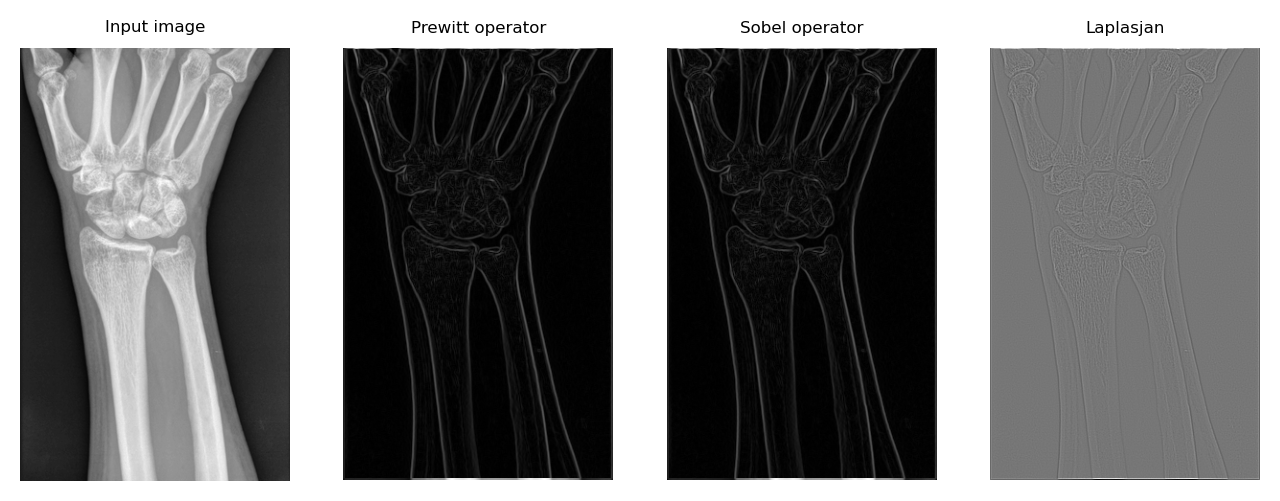

In [69]:
def sobel_gradient(image):
  window_x = np.array([
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1]                     
  ])
  window_y = window_x.T
  gradient_x = signal.correlate2d(image, window_x)
  gradient_y = signal.correlate2d(image, window_y)
  return gradient_y, gradient_x
    
def prewitt_gradient(image):
  window_x = np.array([
    [-1, 0, 1],
    [-1, 0, 1],
    [-1, 0, 1]                     
  ])
  window_y = window_x.T
  gradient_x = signal.correlate2d(image, window_x)
  gradient_y = signal.correlate2d(image, window_y)
  return gradient_y, gradient_x

def laplacian(image):
  window = np.array([
    [-1, -1, -1],
    [-1, 8, -1],
    [-1, -1, -1]                     
  ])
  laplacian_image = signal.convolve2d(image, window)
  return laplacian_image

calculate_magnitude = lambda gradient_x, gradient_y: np.sqrt(gradient_x**2 + gradient_y**2)

sobel_gradient_y, sobel_gradient_x = sobel_gradient(image)
sobel = calculate_magnitude(sobel_gradient_x, sobel_gradient_y)
prewitt_gradient_y, prewitt_gradient_x = prewitt_gradient(image)
prewitt = calculate_magnitude(prewitt_gradient_x, prewitt_gradient_y)
laplacian_image = laplacian(image)

plt.figure(figsize=(8, 6), dpi=200)
plt.subplot(1, 4, 1)
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.title("Input image", fontsize=6)
plt.subplot(1, 4, 2)
plt.imshow(prewitt, cmap='gray')
plt.axis('off')
plt.title("Prewitt operator", fontsize=6)
plt.subplot(1, 4, 3)
plt.imshow(sobel, cmap='gray')
plt.axis('off')
plt.title("Sobel operator", fontsize=6)
plt.subplot(1, 4, 4)
plt.imshow(laplacian_image, cmap='gray')
plt.axis('off')
plt.title("Laplasjan", fontsize=6)
plt.show()

# Algorytm Canny'ego
Wieloetapowy algorytm służący do wykrywania krawędzi. 

1. Filtracja obrazu filtrem Gaussa w celu usunięcia drobnych szumów poprzez rozmycie obrazu wejściowego. Zmniejszaja to prawdopodobieństwo błędnego wykrywania krawędzi spowodowanych szumem.
2. Obliczenie pochodnych kierunkowych, czyli gradientu, korzystając z operatorów kierunkowych np. operatora Sobela. Szukanie natężenia gradientu obrazu. Można użyć również operatora Prewitta, jednak znalezione krawędzie będą nieco grubsze, jaśniejsze i bardziej wyraźne. Nie ma to jednak dużego znaczenia na jakość przetwarzania.
3. Określenie kierunku krawędzi na obrazie poprzez obliczenie kąta gradientu. Kąt detekcji krawędzi został zawężony do 4 przypadków reprezentujących: pion, poziom i dwie przekątne (0,45,90 i 135 stopni)

Kroki 2 i 3 umożliwiają znalezienie intensywności i kierunku zmian jasności w obrazie, innymi słowy określenie potencjalnych krawędzi.

5. Supresja nie-maksymalna w celu wyostrzenia obrazu. Dla każdego piksela na obrazie gradientu sprawdza się, czy piksel jest lokalnym maksimum w swoim kierunku na obrazie gradientu. Jeśli nie jest maksimum, piksel jest ustawiany na zero, co oznacza ignorowanie go w dalszych krokach jako potencjalnej krawędzi. W przeciwnym razie piksel może być krawędzią.
6. Podwójne progowanie (progi niski i wysoki) umożliwia odróżnienie silnych, słabych i nieistotnych krawędzi. Silne krawędzie są bezpośrednio zaznaczone jako istotne, słabe krawędzie są tymczasowo zachowane, a pozostałe są odrzucane.
7. Śledzenie krawędzi przez histerezę to ostatni krok algorytmu. Używa on zasady histerezy do decydowania, które ze słabych krawędzi powinny być ostatecznie traktowane jako istotne. Słabe krawędzie są zachowywane tylko wtedy, gdy są połączone z silnymi krawędziami, co pozwala na eliminację izolowanych słabych krawędzi, które są najprawdopodobniej spowodowane szumem.

In [116]:
def my_gaussian_filter(image, sigma=3):
    
    def calculate_padding_size(kernelSize) -> int:
        if kernelSize==1:
          return 1
        else:
          return int(kernelSize / 2)
        
    def calculate_gaussian_mask(sigma):
      filter_size = 2 * int(4 * sigma + 0.5) + 1
      gaussian_filter = np.zeros((filter_size, filter_size), np.float32)
      
      m = filter_size//2
      n = filter_size//2
        
      for x in range(-m, m+1):
        for y in range(-n, n+1):
          x1 = 2*np.pi*(sigma**2)
          x2 = np.exp(-(x**2 + y**2)/(2* sigma**2))
          gaussian_filter[x+m, y+n] = (1/x1)*x2 
      return gaussian_filter 
    
    mask = calculate_gaussian_mask(sigma)
    padXsize = calculate_padding_size(mask.shape[1]) 
    padYsize = calculate_padding_size(mask.shape[0]) 
    padded_matrix = np.pad(image, ((padYsize, padYsize), (padXsize, padXsize)), mode='constant')
    final_image = np.zeros_like(image)
    for y in range (padYsize,image.shape[0] + padYsize):
        for x in range (padXsize,image.shape[1] + padXsize):
            final_image[y - padYsize, x -padXsize] = np.sum(np.multiply(padded_matrix[y - padYsize : y + padYsize + 1,x - padXsize : x + padXsize + 1], mask))
    return final_image

def calculate_gradients(image):
    def sobel_gradient(image):
        window_x = np.array([
          [-1, 0, 1],
          [-2, 0, 2],
          [-1, 0, 1]                     
          ])
        window_y = window_x.T
        gradient_x = signal.correlate2d(image, window_x)
        gradient_y = signal.correlate2d(image, window_y)
        return gradient_y, gradient_x
    
    gradient_magnitude = lambda gradient_x, gradient_y: np.sqrt(gradient_x**2 + gradient_y**2)
    gradient_angle = lambda gradient_x, gradient_y: np.arctan(gradient_y/gradient_x)
    
    gradient_y, gradient_x = sobel_gradient(image)
    g_mag = gradient_magnitude(gradient_x, gradient_y)
    g_angle = gradient_angle(gradient_x, gradient_y)
    return g_mag, g_angle

def non_maximum_supression(image, gradient_magnitude, gradient_angle):
    pixel_forward = 255
    pixel_backward = 255
    potential_edges = np.zeros_like(image)
    angle = np.rad2deg(gradient_angle)+180
    
    for i in range(1, gradient_magnitude.shape[0] - 2):
        for j in range(1, gradient_magnitude.shape[1] - 2):
            if (0 <= angle[i, j] < 22.5) or (157.5 <= angle[i, j] <= 180) or (337.5 <= angle[i, j] <= 360) :
                pixel_forward = gradient_magnitude[i, j + 1]
                pixel_backward = gradient_magnitude[i, j - 1]
            elif (22.5 <= angle[i, j] < 67.5) or (202.5 <= angle[i, j] < 247.5):
                pixel_forward = gradient_magnitude[i + 1, j - 1]
                pixel_backward = gradient_magnitude[i - 1, j + 1]
            
            elif (67.5 <= angle[i, j] < 112.5) or (247.5 <= angle[i, j] < 292.5):
                pixel_forward = gradient_magnitude[i + 1, j]
                pixel_backward = gradient_magnitude[i - 1, j]
            else:
                pixel_forward = gradient_magnitude[i - 1, j - 1]
                pixel_backward = gradient_magnitude[i + 1, j + 1]
    
            potential_edges[i, j] = image[i, j] if gradient_magnitude[i, j] > pixel_forward and gradient_magnitude[i, j] > pixel_backward else 0
    return potential_edges

def otsu_threshold(image, high_coef, low_coef):
    high_threshold = image.max() * high_coef;
    low_threshold = high_threshold * low_coef ;
    return high_threshold, low_threshold

def double_threshold(potential_edges, gradient_magnitude, low_coef=0.045, high_coef=0.085 ):
    high, low = otsu_threshold(image, high_coef, low_coef) 
    strong_edges = np.where(potential_edges >= high, potential_edges, 0) 
    weak_edges = np.where((low <= potential_edges) & (potential_edges <= high), potential_edges, 0) 
    return strong_edges, weak_edges

def edge_hysteresis(strong_edges, weak_edges):
    final_edges = np.copy(strong_edges)
    se = np.array([
        [1, 1, 1],
        [1, 0, 1],
        [1, 1, 1]                     
        ])  
    for i in range(1, strong_edges.shape[0] - 2):
        for j in range(1, strong_edges.shape[1] - 2):
            if (weak_edges[i, j] == 1):
                try:
                    if (np.max(strong_edges[i - 1 : i + 2, j - 1 : j + 2] * se) > 0):
                        final_edges[i, j] = 1
                except IndexError as e:
                    pass
    return final_edges


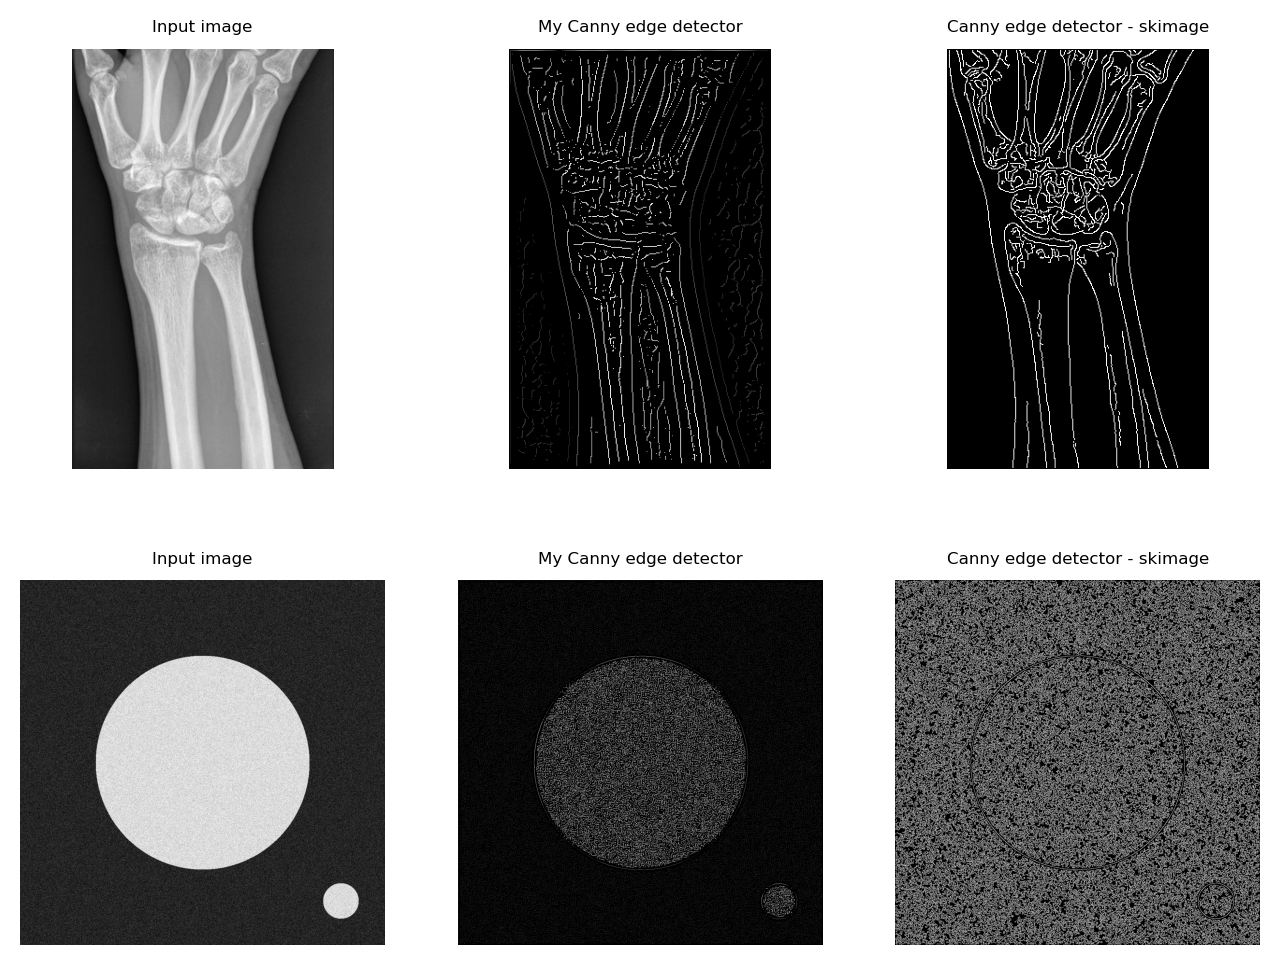

In [120]:
def canny(image, sigma=1.0):
    image = my_gaussian_filter(image, sigma)
    grad_magnitude, grad_angle = calculate_gradients(image)
    potential_edges = non_maximum_supression(image, grad_magnitude, grad_angle)
    strong_edges, weak_edges = double_threshold(potential_edges, grad_magnitude)
    edges = edge_hysteresis(strong_edges, weak_edges)
    return edges

my_canny = canny(image, sigma=3.0)
skimage_canny = feature.canny(image)

my_canny_circle = canny(circle, sigma=2.0)
skimage_canny_circle = feature.canny(circle)

plt.figure(figsize=(8, 6), dpi=200)
plt.subplot(2, 3, 1)
plt.imshow(image, cmap='gray')
plt.title("Input image", fontsize=6)
plt.axis('off')
plt.subplot(2, 3, 2)
plt.imshow(my_canny, cmap='gray')
plt.title("My Canny edge detector", fontsize=6)
plt.axis('off')
plt.subplot(2, 3, 3)
plt.imshow(skimage_canny, cmap='gray')
plt.title("Canny edge detector - skimage", fontsize=6)
plt.axis('off')
plt.subplot(2, 3, 4)
plt.imshow(circle, cmap='gray')
plt.title("Input image", fontsize=6)
plt.axis('off')
plt.subplot(2, 3, 5)
plt.imshow(my_canny_circle, cmap='gray')
plt.title("My Canny edge detector", fontsize=6)
plt.axis('off')
plt.subplot(2, 3, 6)
plt.imshow(skimage_canny_circle, cmap='gray')
plt.title("Canny edge detector - skimage", fontsize=6)
plt.axis('off')
plt.show()

# Segmentacja wykorzystująca techniki uczenia maszynowego i głębokiego uczenia
Stanowią zaawansowane metody segmentacji oferujące ulepszenia zarówno w dokładności, jak i w zdolności do generalizacji w porównaniu do tradycyjnych metod.

- Techniki uczenia maszynowego
Zwykle wykorzystywały klasyfikatory, takie jak maszyny wektorów nośnych (SVM), drzewa decyzyjne czy algorytmy k-średnich, do klasyfikowania pikseli na podstawie ich cech, takich jak kolor, tekstura czy krawędzie.
- Uczenie głębokie
To modele, które mogą automatycznie wykrywać i uczyć się skutecznych cech z danych. Sieci neuronowe, szczególnie konwolucyjne sieci neuronowe (CNN), stały się standardem w segmentacji obrazu dzięki ich zdolności do przetwarzania przestrzennego kontekstu obrazów. Jedną z najpopularniejszych architektur sieci zaprojektowanej specjalnie dla potrzeb segmentacji przypadków medycznych stanowi sieć U-Net. Swoją nazwę wzięła od charakterystycznej budowy warstw endokeda i dekodera (litera U), dzięki czemu sieć ma możliwości precyzyjnej lokalizacji przy jednoczesnym zachowaniu kontekstu. 